# ASL Alphabet Classifier Test


### The goal of this Sign2 variation is to experiment with using Mixup Regularization
(See "mixup: Beyond Empirical Risk Minimization" - Hongyi Zhang, Moustapha Cisse, Yann N. Dauphin, David Lopez-Pazj, 2018;  https://arxiv.org/abs/1710.09412) 

<br>

#### Datasource: 
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>

<br>

This is a prototype, playing with FastAI using Resnet34 to classify American Sign Language alphabet.  It's basically Notebook #2 from the MOOC on a "clean" dataset.  We get great results ... but the data is really contrived.  It's highly likely the model will overfit, however it's a good test of the library.
<br>
<br>
### Data Wrangling info
The data has been reorganized to put sign images in labelled directories, making it easy to import and sort.
We use 2 main data directories and concatenate them together.  the 2nd dataset consists of personally captured images, created using the same notebook that does inference.  We capture every frame of a video and automatically place them in the chosen directory.  The notebook will create the main directory and the label-directory if they don't exist.

<img src="../docs/images/2021-01-13_00-57.png"><br>

In [1]:
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

RUN_NAME = '20210113 - resnet34 2 run new data a-rerun'

import matplotlib.pyplot as plt
# set sensible default parameters for matplotlib
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai

# trying weights and biases 

%env WANDB_WATCH=false

# import wandb
# from fastai.callback.wandb import *

# wandb.init(project="asl-sign-language-recognition")
# wandb.run.name = RUN_NAME

plt.style.use('dark_background')


env: WANDB_WATCH=false


In [2]:
path = '../data/external/Training Set'
path2 = '../data/frank-ledlights-L'

<br>
<br>

## Check for an available GPU

In [3]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER


<br>
<br>

### Check for Dataset Imbalance

In [4]:
from string import ascii_uppercase
import numpy as np
import operator
import matplotlib.pyplot as plt

image_files = {}
image_files_qty = {}

# loop through all the characters to build dictionaries of image files and quartity of each category
for c, i in zip(ascii_uppercase, np.arange(len(ascii_uppercase))):
    image_files[c] = get_image_files(path + f'/{c}')
    if path2 != None:
        image_files[c] += get_image_files(path2 + f'/{c}')

        
    l = len(image_files[c])
    image_files_qty[c] = l
    
# custom code since we don't use 'Z'
image_files.pop('J')
image_files_qty.pop('J')
image_files.pop('Z')
image_files_qty.pop('Z')

# Get the character with the largest and smallest number of entries
maxqc = max(image_files_qty, key=image_files_qty.get)
minqc = min(image_files_qty, key=image_files_qty.get)


print()
print(f'Character with the most images:   {maxqc},   with {image_files_qty[maxqc]} images')
print(f'Character with the least images:  {minqc},   with {image_files_qty[minqc]} images')





Character with the most images:   X,   with 5986 images
Character with the least images:  A,   with 3629 images


<br>
<br>

## Display the number of image files for each category

Text(0, 0.5, 'Sample Size')

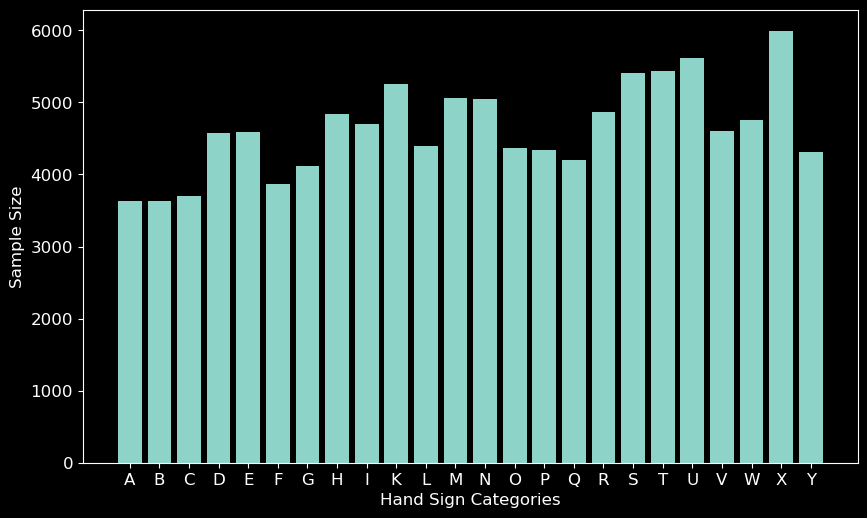

In [5]:
# plt.hist(image_files_qty.items)
plt.bar(image_files_qty.keys(), image_files_qty.values())
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')

<br>
<br>

### Balance the Dataset with Oversampling or Undersampling

In [6]:
import pandas as pd

maxq = image_files_qty[maxqc] # the quantity of the largest category
minq = image_files_qty[minqc] # the quantity of the smallest category

CHOSEN_SAMPLE_SIZE = 4000 # use this to control sample sizes



all_image_files = pd.DataFrame(columns=[0])  # holds all the image files in one dataframe
new_image_files_qty = {}

for c, q in iter(image_files_qty.items()):
    df = pd.DataFrame(data=list(image_files[c]), columns=[0])  # create a dataframe from each list
    
#     if q < image_files_qty[maxqc]:
#         df = df.sample(maxq, replace=True).reset_index(drop=True) # oversample
#         all_image_files = pd.concat([all_image_files, df], ignore_index=True)

    # undersample or over sample as needed
    if len(df) >= CHOSEN_SAMPLE_SIZE:
        df = df.sample(CHOSEN_SAMPLE_SIZE, replace=False)  # undersample
    else:
        delta = CHOSEN_SAMPLE_SIZE - len(df)
        df = pd.concat([df, df.sample(delta, replace=(delta > len(df)))], ignore_index=True)  # overrsample
        
    # aggregate the image_files
    all_image_files = pd.concat([all_image_files, df], ignore_index=True)
    new_image_files_qty[c] = len(df)    
#     print(len(df))
    
# TEMPORARY @TODO remove this experiment
# all_image_files = all_image_files.sample(n=1000, replace=False)

all_image_files = all_image_files.sample(n = len(all_image_files))  # shuffle
    
# Needed to pass into the DataBlock    
def get_fnames(path): return list(all_image_files[0])

<br>
<br>

### Ensure the Dataset is Balanced

Text(0, 0.5, 'Sample Size')

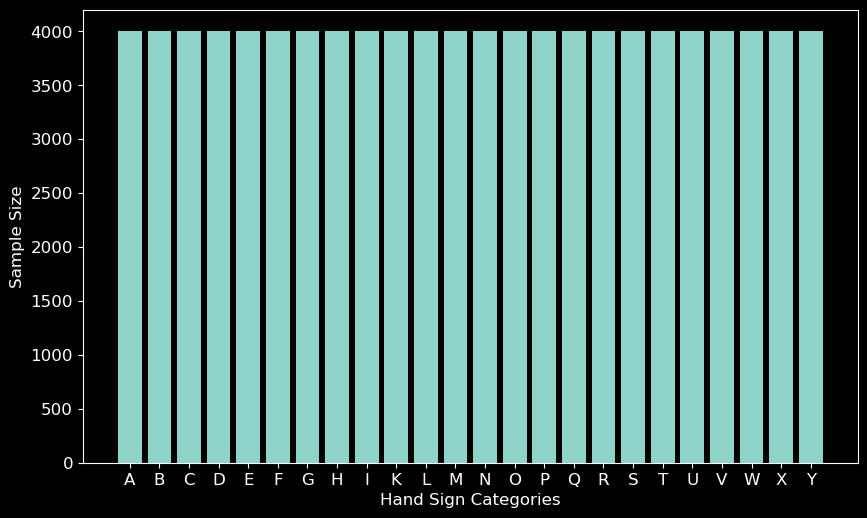

In [7]:
plt.bar(new_image_files_qty.keys(), new_image_files_qty.values())
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')

<br>
<br>

<br>

### Create the DataBlock, while Resizing and Augmenting

In [8]:
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(300, method='bilinear')) #,
#     batch_tfms=aug_transforms(do_flip=True, batch=True, max_zoom=1.0, mult=3))


<br>
<br>

<br>

### Load the Data by Path

In [9]:
dls = signs.dataloaders(path, bs=32)
# wandb.log({'dataset':'../data/external/Trainiing Set'})

<br>

### Verify the Training and Validation Batches

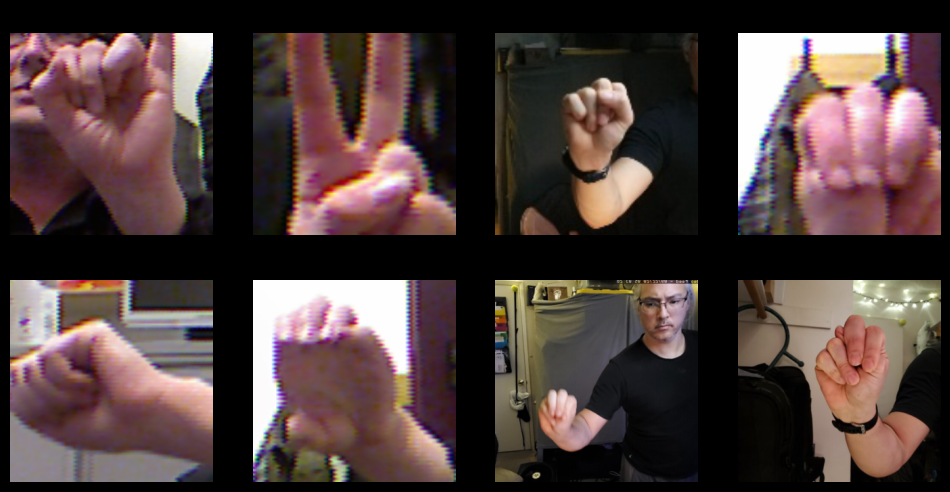

In [10]:
dls.train.show_batch(max_n=8, nrows=2)

<br>
<br>

### Define the model (Resnet34) and fit

In [11]:
# wandb.log()
learn = cnn_learner(dls, arch=resnet34, metrics=[error_rate, accuracy]) #  , \
#                          SaveModelCallback()])
# learn = cnn_learner(data, models.densenet121, metrics=[accuracy, top_k_accuracy], callback_fns=[WandbCallback])

<br>
<br>

### Look at the Loss Function, Optimization Function and Model Architecture

In [12]:
print('\nLoss Function: ', learn.loss_func)
print('\nOptimization Function: ', learn.opt_func)
# print('\n\n', learn.model)


Loss Function:  FlattenedLoss of CrossEntropyLoss()

Optimization Function:  <function Adam at 0x7fa6573bfa60>


<br>
<br>
<br>

## Manually find a learning rate between the shoulder and the steepest drop.

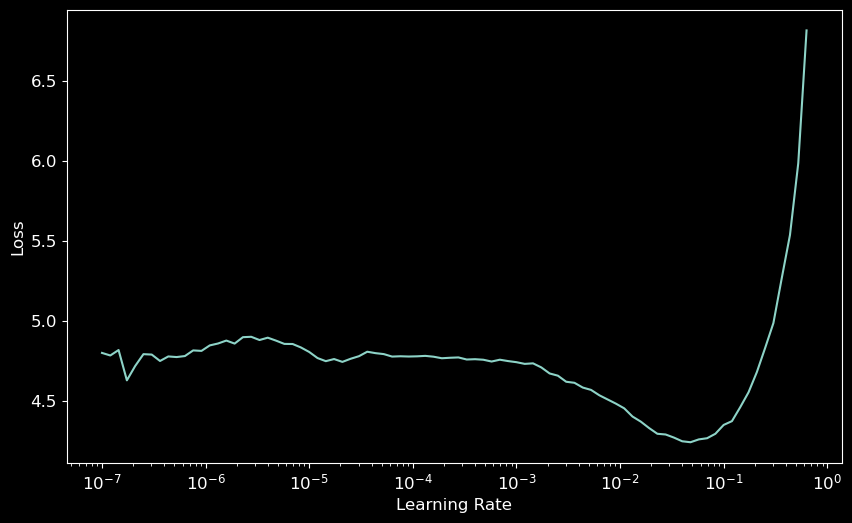

In [13]:
lr_min,lr_steep = learn.lr_find()

In [14]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 4.79e-03, steepest point: 1.10e-02


<br>
<br>
<br>

## Create Callbacks

In [15]:
# Eary stopping callback
early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0075, patience=2)

# Wandb Callback for logging
# wandb_cb = WandbCallback(log_dataset=False, log_model=True, log='all')

# Mixup callback for regularization
mixup_cp = MixUp(alpha=0.5)

<br>
<br>

## Fit the last layers, unfreeze, fit the whole net, with a descriminant LR, all in one go.
Model architecture: 
Filename: ../models/{{RUN_NAME}}.pkl


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.959926,0.267226,0.082292,0.917708,10:41


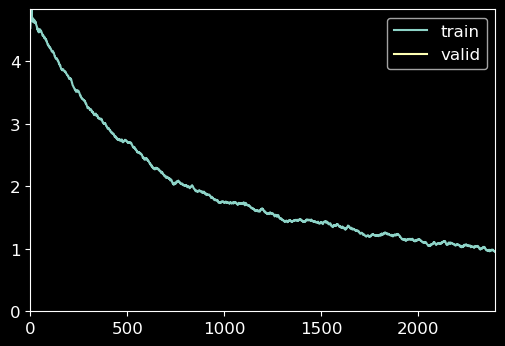

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.369866,0.059487,0.018854,0.981146,15:33
1,0.107661,0.006783,0.001927,0.998073,15:05


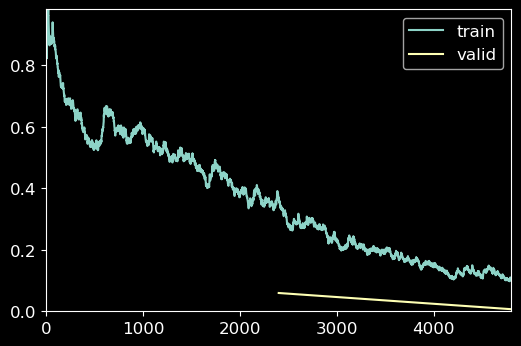

In [16]:
learn.fine_tune(2, freeze_epochs=1, base_lr=lr_min, cbs=[mixup_cp, ShowGraphCallback(), early_stop])


In [17]:
# learn.fit(1, cbs=[mixup_cp, ShowGraphCallback(), early_stop])

<br>
<br>

## Persist the Model

In [18]:
learn.export(f'../models/{RUN_NAME}_add2.pkl')
path = Path('../models')
path.ls(file_exts='.pkl')

(#14) [Path('../models/20210104 - Reboot Wandb.pkl'),Path('../models/20210112 - resnet34 1 run new data a.pkl'),Path('../models/20210112 - resnet34 2 run new data a_add2.pkl'),Path('../models/20210103 - THROWAWAY-a.pkl'),Path('../models/20210112 - resnet50 1 run a.pkl'),Path('../models/2021011 - Mixupa.pkl'),Path('../models/20210103 - Reboot.pkl'),Path('../models/20210112 - resnet18 a.pkl'),Path('../models/20210112 - resnet50 a.pkl'),Path('../models/20210112 - resnet34 1 run new data a_add1.pkl')...]

<br>
<br>

<br>

### Plot Losses

Text(0.5, 0, 'Batches Processed')

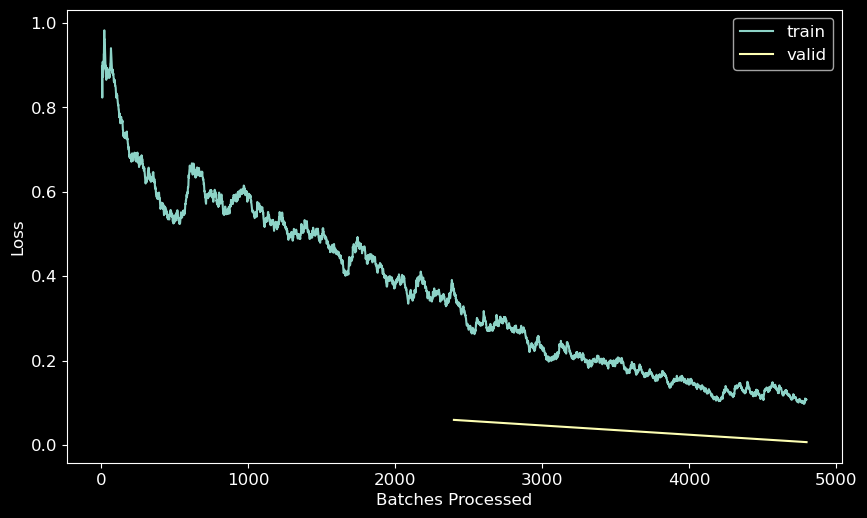

In [19]:
learn.recorder.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Batches Processed')

In [20]:
# learn

<br>

### Visualize with a confusion Matrix

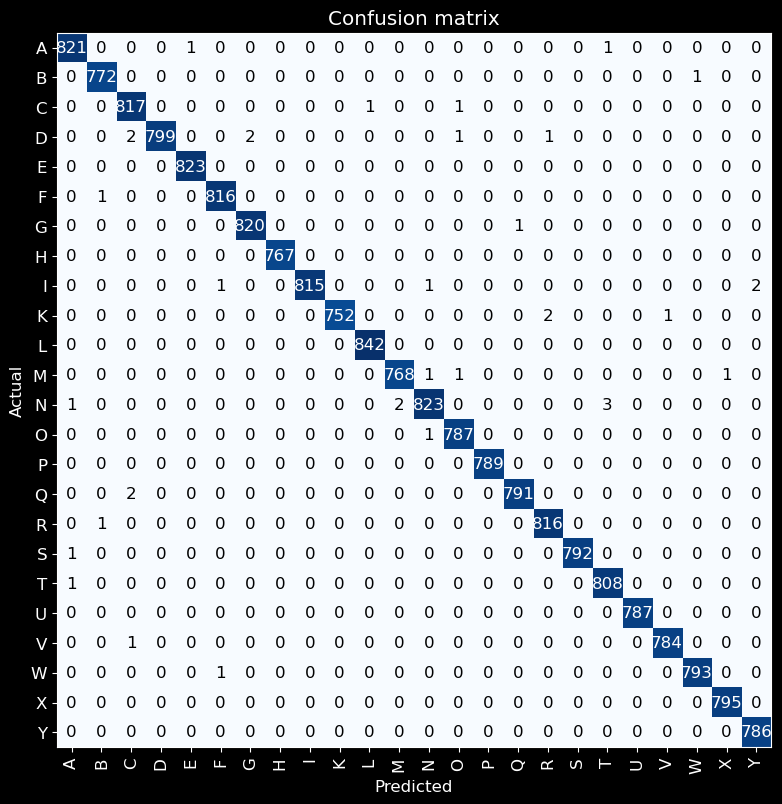

In [21]:
## @TODO after updating FastAI and WandB, this cell interrupts the kernel somehow

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

<br>
<br>

## Classification Report

In [22]:
interp.print_classification_report()

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       823
           B       1.00      1.00      1.00       773
           C       0.99      1.00      1.00       819
           D       1.00      0.99      1.00       805
           E       1.00      1.00      1.00       823
           F       1.00      1.00      1.00       817
           G       1.00      1.00      1.00       821
           H       1.00      1.00      1.00       767
           I       1.00      1.00      1.00       819
           K       1.00      1.00      1.00       755
           L       1.00      1.00      1.00       842
           M       1.00      1.00      1.00       771
           N       1.00      0.99      0.99       829
           O       1.00      1.00      1.00       788
           P       1.00      1.00      1.00       789
           Q       1.00      1.00      1.00       793
           R       1.00      1.00      1.00       817
           S       1.00    

<br>

### Show the top 5 most error prone images

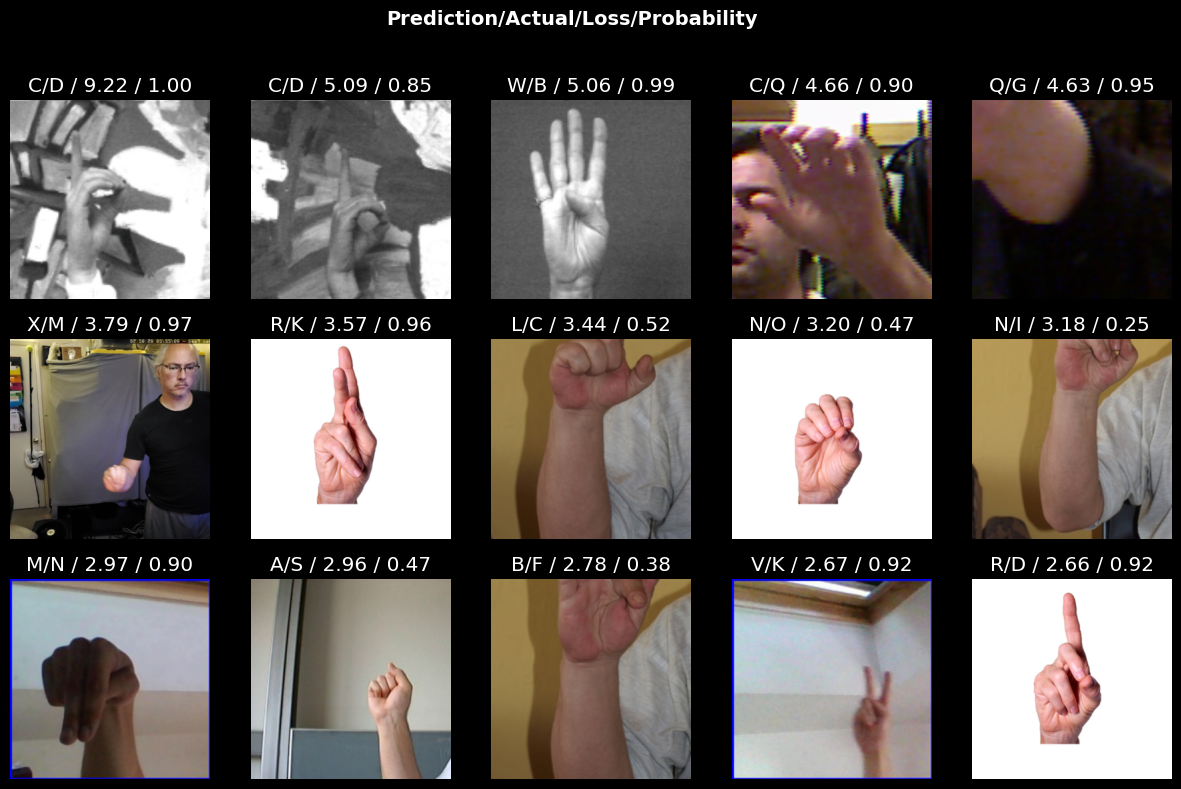

In [23]:
interp.plot_top_losses(15, nrows=3)

<br>

### ~~Clean the images that were hard to interpret and obviously bad~~

(I had to remove this section as it was using too much RAM and crashing the kernel)

In [24]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

<br>
<br>
<hr>
<br>
<br>




In [25]:
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)

In [26]:
# learn.save(os.path.join(wandb.run.dir, "20210103a.h5"))

In [27]:
# learn.save(os.path.join(wandb.run.dir, "20210103.h5"))

In [28]:
# learn.save("model.h5")

In [29]:
# wandb.run.path


In [30]:
# %cd ..
# learn_inf.save('save/200921-0201-export-resnet101-FALL-tune2ft-tune6un-tune2ft-F-t2ft-ut3-t2ft-t2ft')
# %cd notebooks

<br>
<br>
<br>

## Clean up

<br>

In [31]:
# wandb.join()

In [32]:
# wandb.finish()

<br>
<br>
<br>
<hr>
<br>

# Log

* started to plot the learning rates and started to use that information while fitting.
* Downgraded to resnet34 @ 300px in order to increase the resolution fed to the model from 128px to 300px - this made a major difference.
* Decreased the number of training epochs to 6 after experimenting to find the sweet spot. - also positive change
* Changed to exclusively use fine-tune() with it's built in freeze_epochs parameter
* Changed the Batch Size in order to bring the arch back to resnet101 @300px
* Cleaned up the markdown, removed cells and reordered the rest.
* Added an Early Stop.  Starting with 0.01 delta.  
* Now moving to 0.1 delta
* Integrated wandb to keep track of experiments.
* added section to balance the dataset through oversampling.

** Attempting a batch size of 12 and 384px with resnet101.  long training times.
** Also increased the epochs to 4 on the final layer and 7 on the rest.
    